# DL Challenge

Team:
German Novykov
Alexiy Pidnebesnyi
Mark Vaykul

3 models, training our model from scratch, fine tuning, using tensorflow and pre trained models, as well as pytorch with google vit from Huggingface.


2st model fine tuning pre trained model ResNet

3st model Google vit. by far the strongest one but can recognise everything already

1st model, trained only on data provided in the challenge. 


In [89]:
!pip install tensorflow scikit-learn seaborn matplotlib opencv-python torch

In [90]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

Load the data with method **image_dataset_from_directory**

Images automatically are given classes based on folder names, ['Cat', 'Cheetah', 'Leopard', 'Lion', 'Tiger']

In [91]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set the parameters for your data
batch_size = 32
image_size = (160,160)
validation_split = 0.2

# Create the training dataset from the 'train' directory
train_ds = image_dataset_from_directory(
    directory='./train/train',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Create the validation dataset from the 'train' directory
validation_ds = image_dataset_from_directory(
    directory='./train/train',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

test_ds = image_dataset_from_directory(
    directory='./test',
    batch_size=batch_size,
    image_size=image_size
)

class_names = train_ds.class_names
print(class_names)
print(train_ds)
for images, labels in train_ds.take(1):  # 'take(1)' takes just one batch from the dataset
    print("Shape of training images:", images.shape)  # Prints the shape of images
    print("Shape of training labels:", labels.shape)

Found 2026 files belonging to 5 classes.
Using 1621 files for training.
Found 2026 files belonging to 5 classes.
Using 405 files for validation.
Found 473 files belonging to 1 classes.
['Cat', 'Cheetah', 'Leopard', 'Lion', 'Tiger']
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Shape of training images: (32, 160, 160, 3)
Shape of training labels: (32,)


# EDA and Data Augmentation

Let's take a look at the data. We did Edge detection on the images and the best one looks like kernel 5x5 higher treshold The pictures are loaded with resolution of 64x64 

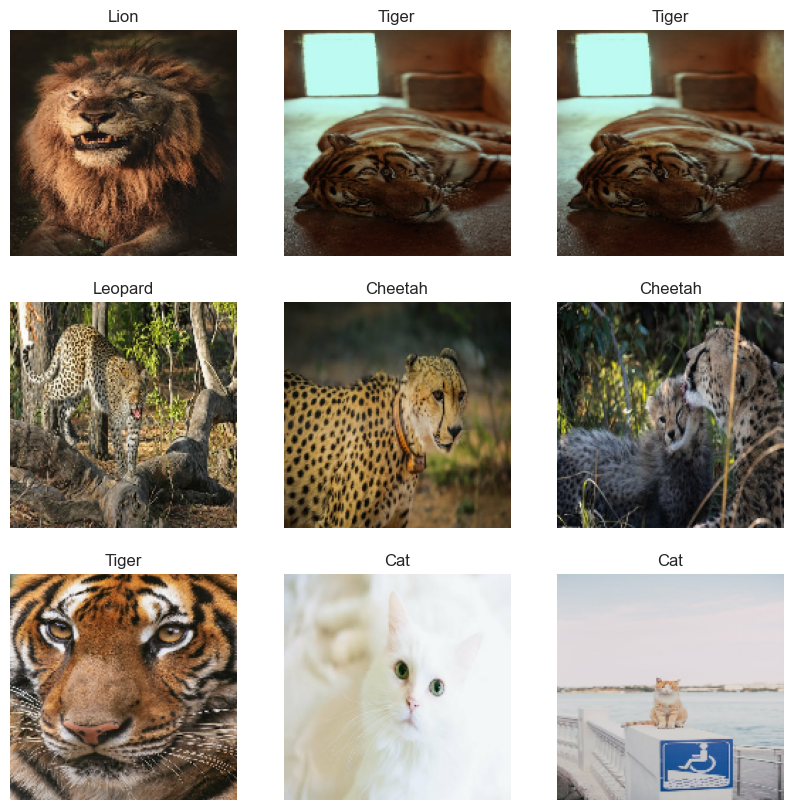

In [92]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

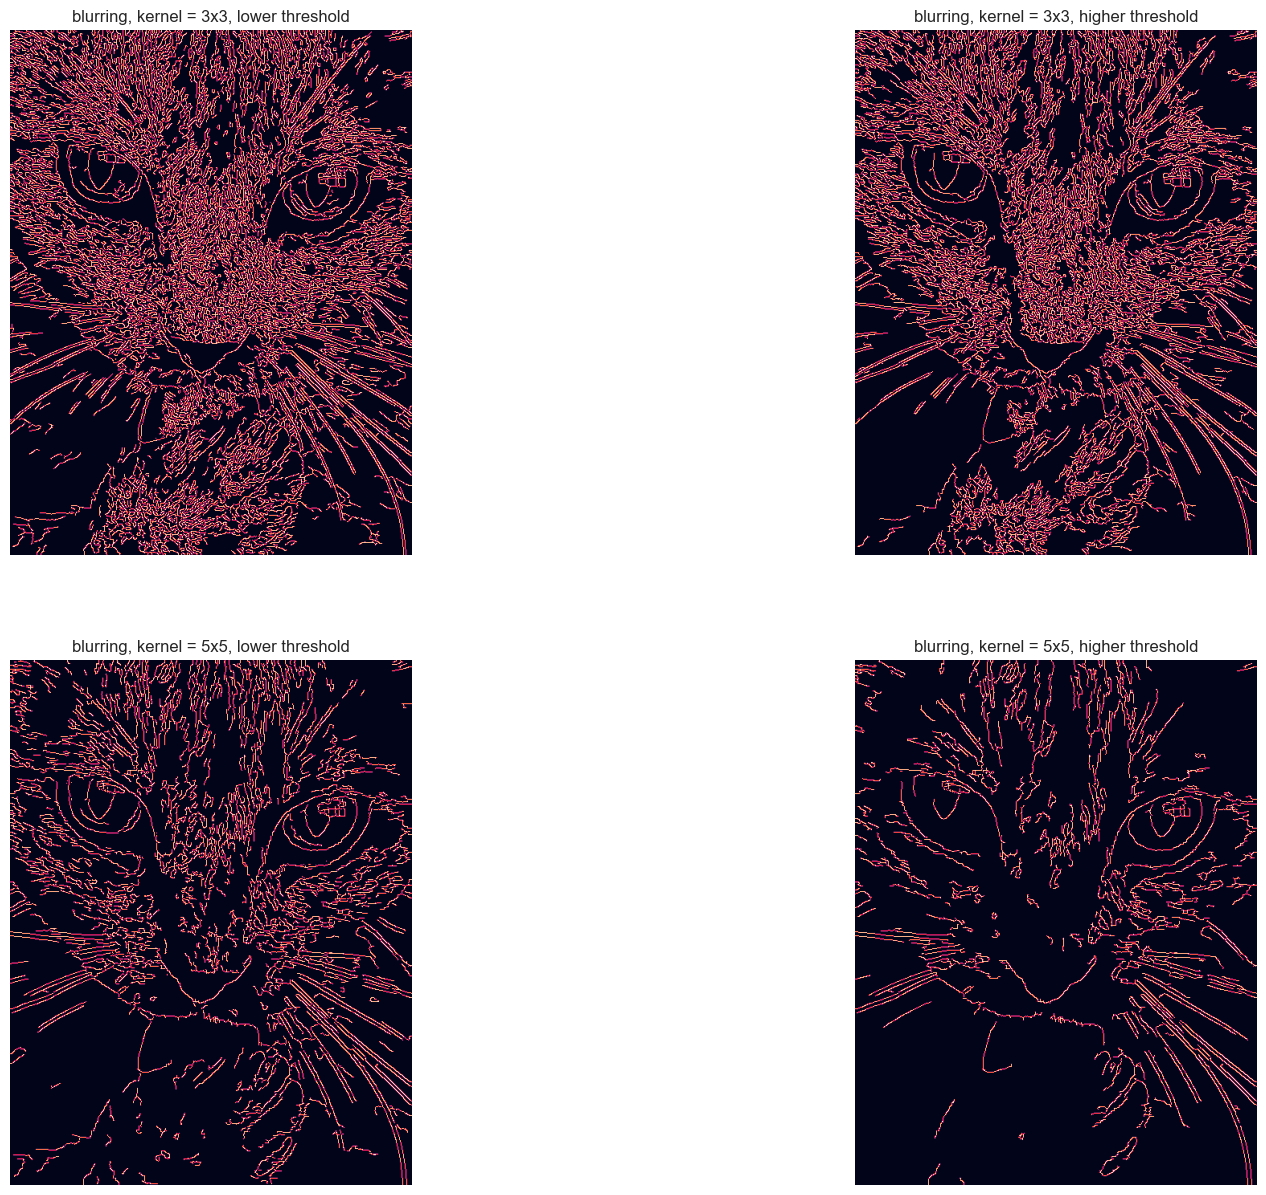

In [93]:
import cv2
img_orig = cv2.imread('./train/train/Cat/Cat_Cat91.jpg')

# set the lower and upper threshold
med_val = np.median(img_orig)
lower = int(max(0, .7 * med_val))
upper = int(min(255, 1.3 * med_val))

# blurring with ksize = 3
img_k3 = cv2.blur(img_orig, ksize = (3, 3))
# canny detection with different thresholds
edges_k3 = cv2.Canny(img_k3, threshold1 = lower, threshold2 = upper)
edges_k3_2 = cv2.Canny(img_k3, lower, upper + 75)

# blurring with ksize = 5 
img_k5 = cv2.blur(img_orig, ksize = (5, 5))
# canny detection with different thresholds
edges_k5 = cv2.Canny(img_k5, lower, upper)
edges_k5_2 = cv2.Canny(img_k5, lower, upper + 75)

# plot the images
images = [edges_k3, edges_k3_2, edges_k5, edges_k5_2]
titles = ['blurring, kernel = 3x3, lower threshold', 
          'blurring, kernel = 3x3, higher threshold', 
          'blurring, kernel = 5x5, lower threshold', 
          'blurring, kernel = 5x5, higher threshold']
plt.figure(figsize = (20, 15))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(titles[i])
        
plt.show()




In [94]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


# 1st Sequential Model

The first model is Sequential model without prior pre-training

First layer is data augmentation, rescaling, then convolution and pooling layer repeated 3 times. Flatten to make the output 1D array. Dense to make output for 5 classes.

In [95]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255), #0-225 -> 0-1
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(160, activation='relu'),
  tf.keras.layers.Dense(5)
])


Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.2329 - loss: 1.6625 - val_accuracy: 0.3037 - val_loss: 1.5308
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3779 - loss: 1.4247 - val_accuracy: 0.3630 - val_loss: 1.4279
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4737 - loss: 1.2855 - val_accuracy: 0.5210 - val_loss: 1.2250
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.4797 - loss: 1.2382 - val_accuracy: 0.4914 - val_loss: 1.2358
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5411 - loss: 1.1338 - val_accuracy: 0.4914 - val_loss: 1.2534


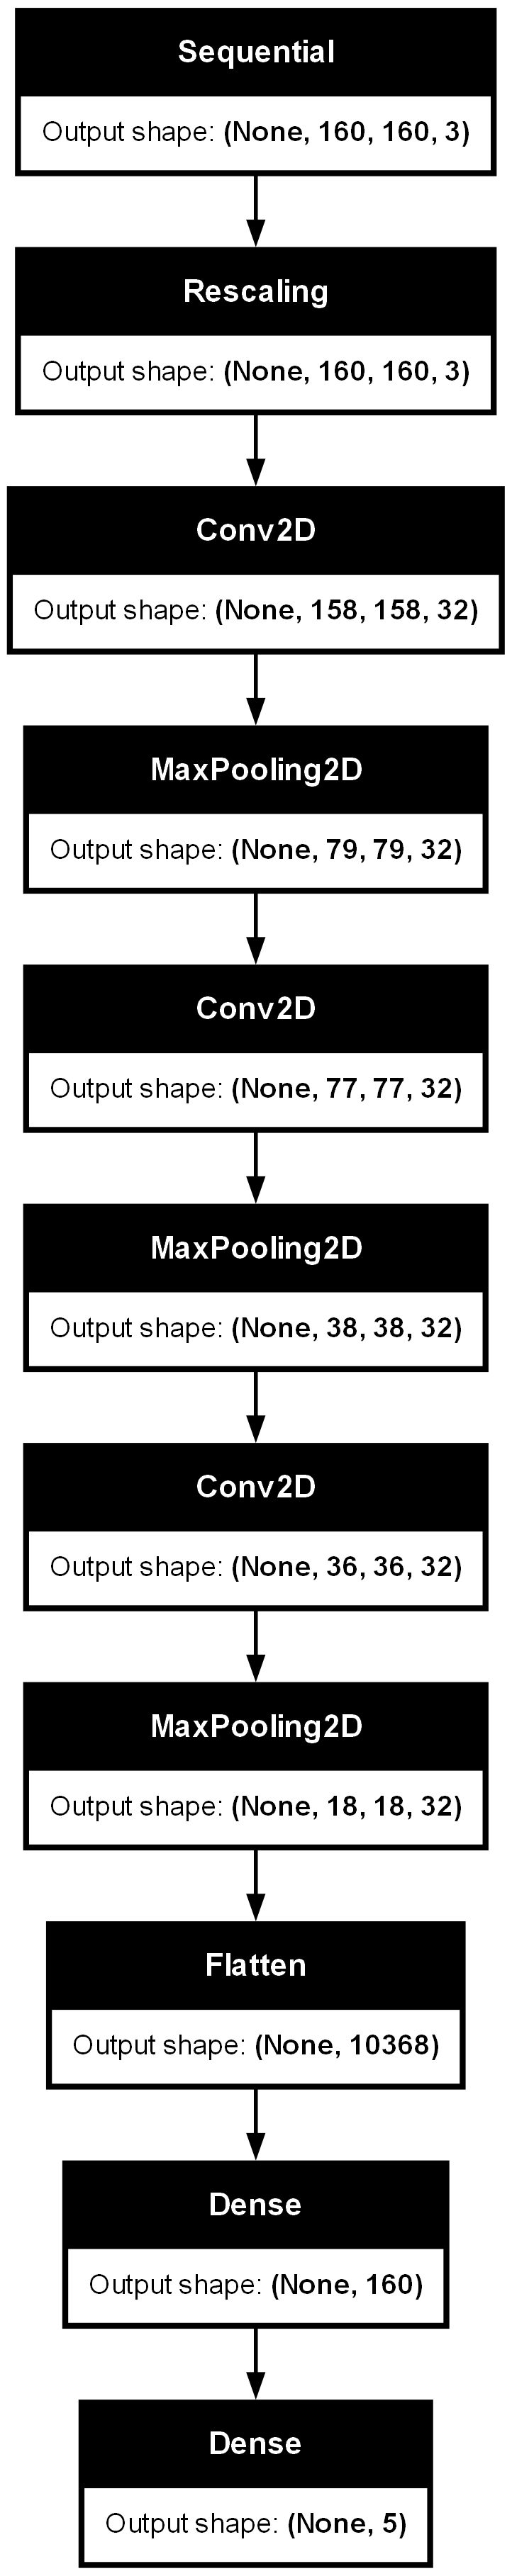

In [96]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

history = model.fit(
  train_ds,
  validation_data=validation_ds,
            epochs = 5
)
tf.keras.utils.plot_model(model, show_shapes=True)


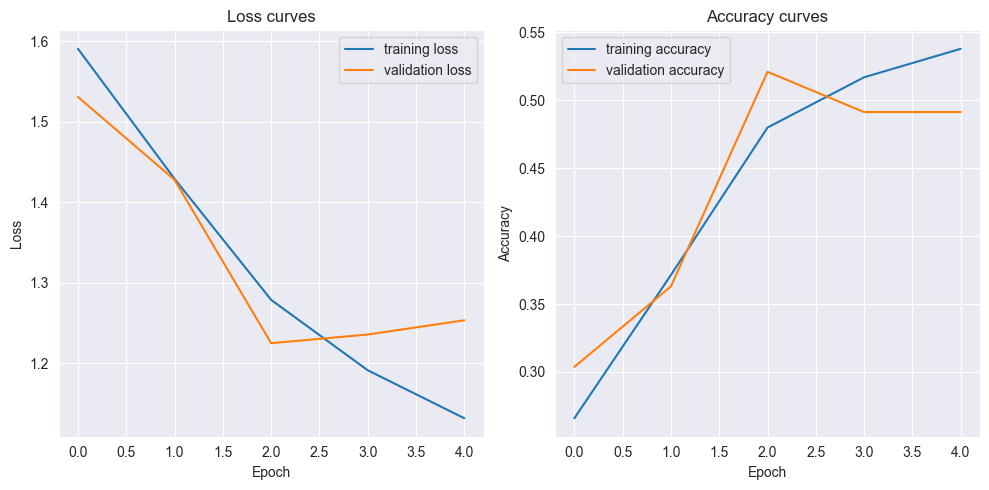

In [97]:
def plotLosses(history):
  # Create a figure and a grid of subplots with a single call
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  # Plot the loss curves on the first subplot
  ax1.plot(history.history['loss'], label='training loss')
  ax1.plot(history.history['val_loss'], label='validation loss')
  ax1.set_title('Loss curves')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  # Plot the accuracy curves on the second subplot
  ax2.plot(history.history['accuracy'], label='training accuracy')
  ax2.plot(history.history['val_accuracy'], label='validation accuracy')
  ax2.set_title('Accuracy curves')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  # Adjust the spacing between subplots
  fig.tight_layout()
  # Show the figure
  plt.show()


plotLosses(history)

# Confusion Matrix

Confusion matrix visualizes models performance based on True Positives, True Negatives, False Positives, False Negatives. 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


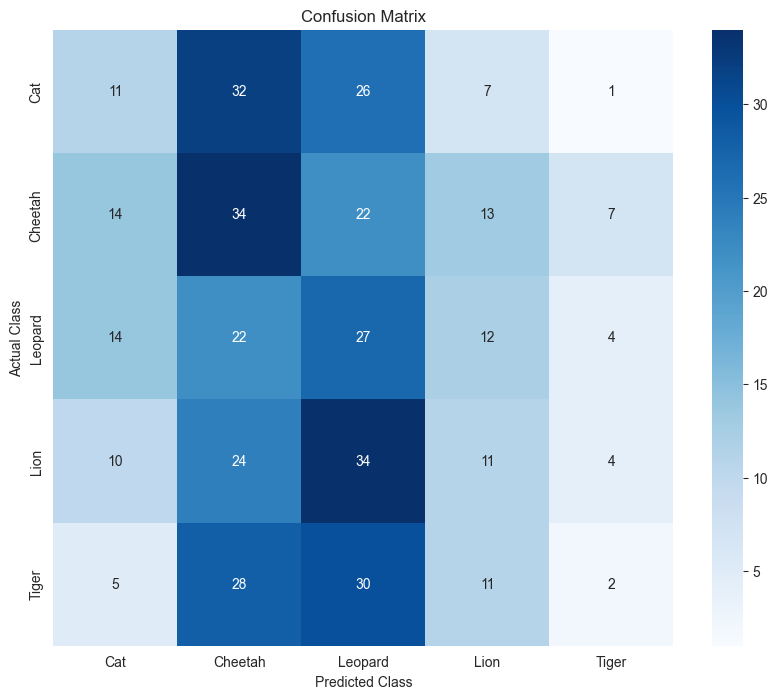

In [98]:

def confusionMatrix(model, validation_ds, class_names):
    # Assume your model and test_ds are already defined and loaded correctly as per your code.
    # predictions = model.predict(validation_ds)
    # predicted_classes = np.argmax(predictions, axis=1)

    # Extract true labels from the test dataset
    # true_labels = []
    # for images, labels in validation_ds:
    #     true_labels.extend(labels.numpy())
    # # 
    # # Calculate the confusion matrix
    # cm = confusion_matrix(true_labels, predicted_classes)
    # 
    # # Plot the confusion matrix
    # plt.figure(figsize=(10, 7))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.title('Confusion Matrix')
    # plt.show()
    
    
    
    pred_probabilities = model.predict(validation_ds, steps=len(validation_ds))
    pred_labels = np.argmax(pred_probabilities, axis=1)
    
    
    predictions = model.predict(validation_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    # Extract true labels from the test dataset
    true_labels = []
    for images, labels in validation_ds:
        true_labels.extend(labels.numpy())
    
    # predicted_classes = np.argmax(predictions, axis=1)
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
confusionMatrix(model, validation_ds, class_names)

In [99]:
import pandas as pd
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)


file_paths = test_ds.file_paths
ids = [fp.split('\\')[-1].split('.')[0] for fp in file_paths]

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_classes
})

submission_df.to_csv('submission.csv', index=False)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


# 2nd MobileNet V2 Model using Transfer Learning

Second model is fine-tuned model based on pre-trained MobileNet V2 model. MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes


In [100]:
# def preprocess_data(image, label):
#     return tf.keras.applications.mobilenet.preprocess_input(image), label
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# train_ds_resnet = train_ds.map(preprocess_data)
# val_ds_resnet = validation_ds.map(preprocess_data)
# test_ds_resnet = test_ds.map(preprocess_data)

base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False


This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [101]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image

In [102]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [103]:
base_model.trainable = False

In [104]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [105]:
inputs = tf.keras.Input(shape=(160, 160, 3))
# x = preprocess_input(inputs)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [106]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [107]:
len(model.trainable_variables)

2

In [108]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [109]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.1652 - loss: 2.0375
initial loss: 2.09
initial accuracy: 0.14


In [110]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.1803 - loss: 2.0670 - val_accuracy: 0.3407 - val_loss: 1.5489
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.3462 - loss: 1.5548 - val_accuracy: 0.5728 - val_loss: 1.1897
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5547 - loss: 1.2024 - val_accuracy: 0.7012 - val_loss: 0.9362
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.6472 - loss: 0.9783 - val_accuracy: 0.7728 - val_loss: 0.7869
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.7315 - loss: 0.7980 - val_accuracy: 0.8025 - val_loss: 0.6828
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7464 - loss: 0.7171 - val_accuracy: 0.8173 - val_loss: 0.6148
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7877 - loss: 0.6454 - val_accuracy: 0.8444 - val_loss: 0.5626
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.7988 - loss: 0.5963 - val_accuracy: 0.8716 - v

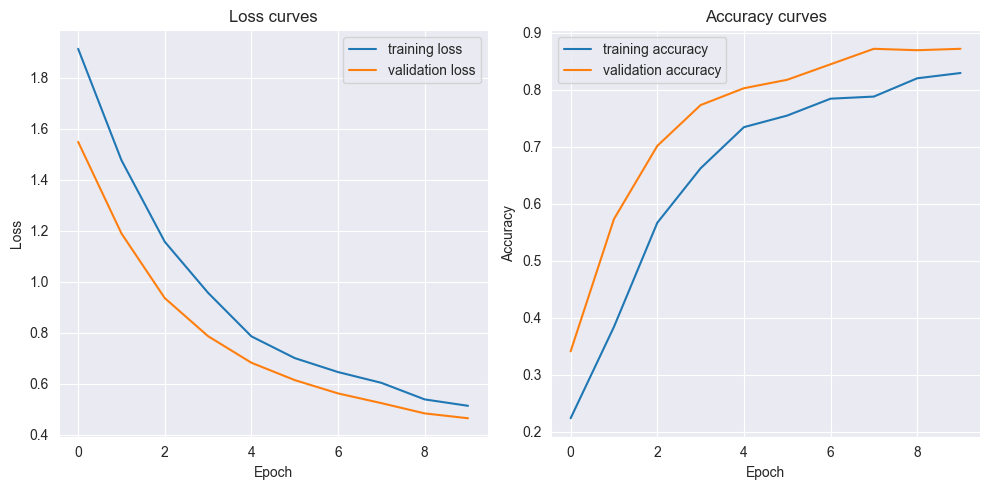

In [111]:
plotLosses(history)

# Fine tuning

In [112]:
base_model.trainable = True

In [113]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [114]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.6773 - loss: 0.8444 - val_accuracy: 0.8864 - val_loss: 0.3948
Epoch 12/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.7799 - loss: 0.6346 - val_accuracy: 0.8889 - val_loss: 0.3785
Epoch 13/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.8330 - loss: 0.5106 - val_accuracy: 0.8889 - val_loss: 0.3433
Epoch 14/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.8534 - loss: 0.4446 - val_accuracy: 0.8963 - val_loss: 0.3264
Epoch 15/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.8712 - loss: 0.3948 - val_accuracy: 0.9037 - val_loss: 0.3108
Epoch 16/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.8858 - loss: 0.3622 - val_accuracy: 0.9037 - val_loss: 0.3025
Epoch 17/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.8852 - loss: 0.3394 - val_accuracy: 0.9012 - val_loss: 0.2978
Epoch 18/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.8956 - loss: 0.2978 - val_acc

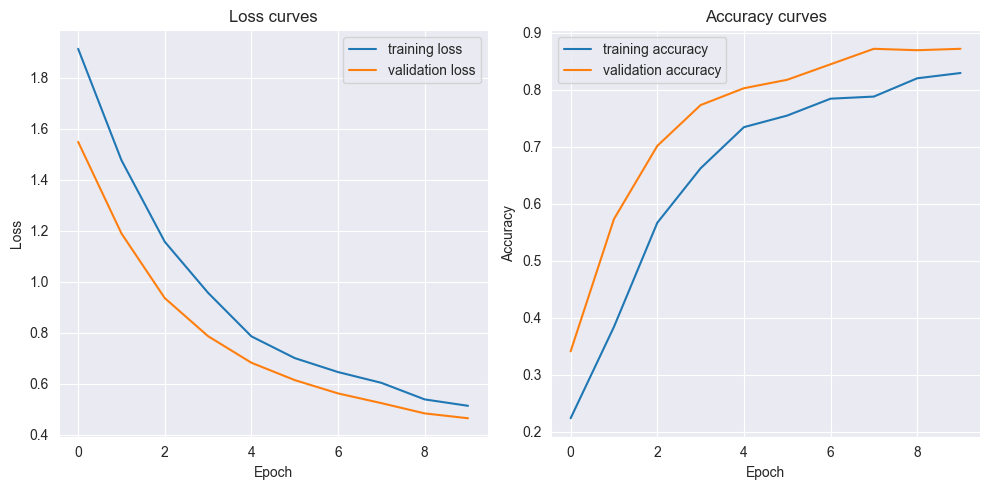

In [115]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_ds)
plotLosses(history)



13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


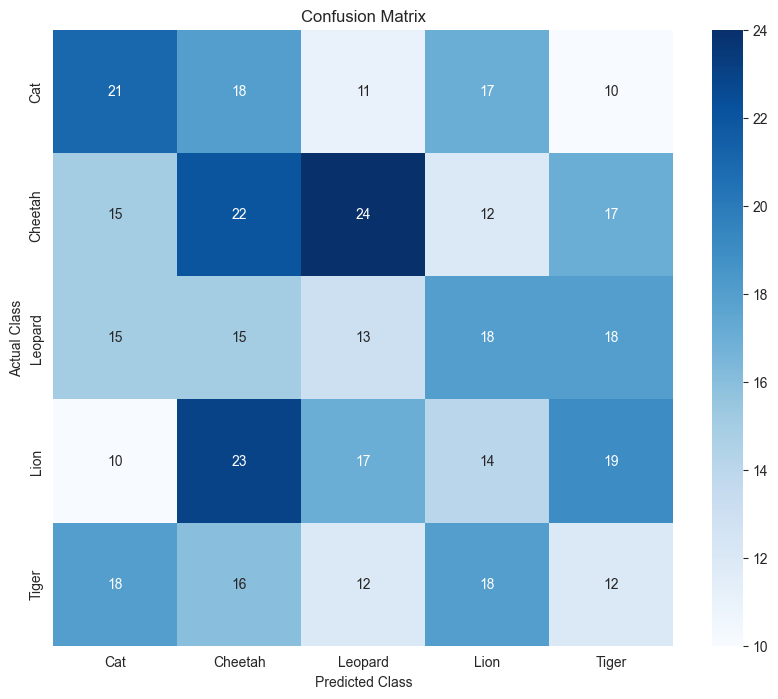

In [116]:
confusionMatrix(model, validation_ds, class_names)


Predictions:
 [4 3 1 2 0 0 2 3 2 1 1 1 2 0 0 1 0 1 3 1 0 1 1 3 0 4 4 3 0 2 2 4]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


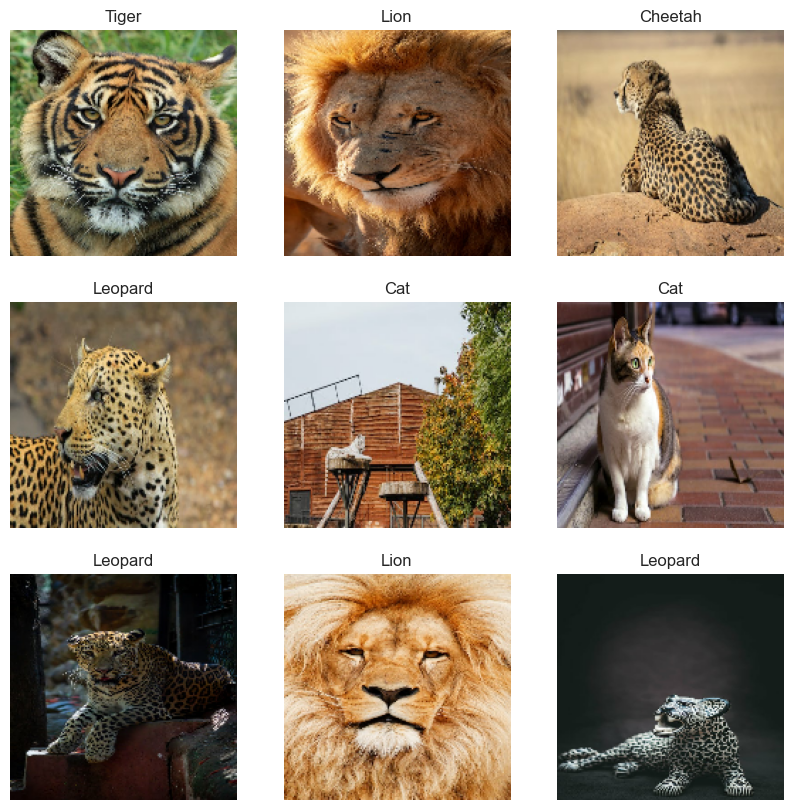

In [117]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

**Submission file for Kaggle**

In [118]:
import pandas as pd
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)


file_paths = test_ds.file_paths
ids = [fp.split('\\')[-1].split('.')[0] for fp in file_paths]

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_classes
})

submission_df.to_csv('submission_mobilenet.csv', index=False)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


# 3rd Google ViT Model using Transfer Learning (google/vit-base-patch16-224)

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224.


In [118]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
full_train_ds = datasets.ImageFolder('./train/train/', transform=transform)

# Splitting the dataset into train and validation sets
train_size = int(0.8 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

# Setup data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [ ]:
from transformers import ViTForImageClassification

# Load the ViT model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# If you need to customize the number of output classes:
model.classifier = torch.nn.Linear(model.config.hidden_size, 5)


In [ ]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 2
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Dictionary to store training and validation loss, accuracy
history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Record training loss and accuracy
    epoch_loss = train_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_accuracy)
    
    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Record validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


In [ ]:
def plotLosses(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    ax1.plot(history['loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['accuracy'], label='Training Accuracy')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    fig.tight_layout()
    plt.show()

# Call the plot function with the history dictionary
plotLosses(history)


In [ ]:
import numpy as np

test_ds = datasets.ImageFolder('./test/', transform=transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model.eval()  # Set the model to evaluation mode

all_predictions = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)
        all_predictions.extend(predicted.cpu().numpy())

# all_predictions now contains the predicted class indices for each test image

import pandas as pd

# Assuming the structure is something like './test/class_name/filename.jpg'
ids = [fp.split('\\')[-1].split('.')[0] for fp, _ in test_ds.imgs]

submission_df = pd.DataFrame({
    'id': ids,
    'label': all_predictions
})
submission_df.to_csv('newsubmission.csv', index=False)